<a href="https://colab.research.google.com/github/rkdwodms/Data-analysis/blob/main/seas_vacc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
import pandas as pd
drive.mount('/gdrive')

# 데이터 불러오기

train = pd.read_csv('/gdrive/My Drive/Colab Notebooks/data/Vacc_seas_train.csv')
test = pd.read_csv('/gdrive/My Drive/Colab Notebooks/data/Vacc_seas_test.csv')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
from sklearn.model_selection import train_test_split

target = 'vacc_seas_f'

train, val = train_test_split(train, test_size=len(test),
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((28102, 40), (14052, 40), (14052, 39))

In [7]:
dels = [col for col in test.columns if ('employment' in col or 'h1n1' in col)]
dels

['h1n1_concern',
 'h1n1_knowledge',
 'doctor_recc_h1n1',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'employment_status',
 'employment_industry',
 'employment_occupation']

In [8]:
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
        
    # new feature
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)

    #h1n1 feature, employment feature del
    dels = [col for col in df.columns if('employment' in col or 'h1n1' in col)]
    df.drop(columns=dels, inplace=True)


    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)


train.shape, val.shape, test.shape

((28102, 32), (14052, 32), (14052, 31))

In [11]:
feature = train.drop(columns=[target]).columns
X_train = train[feature]
y_train = train[target]

X_val = val[feature]
y_val = val[target]

X_test = test[feature]

In [9]:
!pip install --upgrade category_encoders

     |████████████████████████████████| 80 kB 5.0 MB/s 


In [12]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)

)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
accuracy_score(y_val, y_pred)

0.7587532023911187

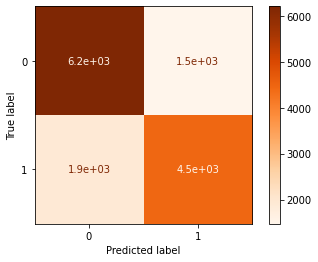

In [13]:
# confusion matrix 분류 모델 성능 평가 지표

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap = plt.cm.Oranges,
                            ax = ax);
plt.show()                

In [16]:
cm = pcm.confusion_matrix
cm
# cm[1][1] #TP : 백신 맞은 사람 잘 예측

array([[6209, 1471],
       [1919, 4453]])

In [21]:
import numpy as np
# 맞춘 예측! 갯수

corr_pred = np.diag(cm).sum()
corr_pred

# 총 예측 갯수 
total_pred = cm.sum()
total_pred

14052

In [22]:
# 재현률, 정밀도 확인

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79      7680
           1       0.75      0.70      0.72      6372

    accuracy                           0.76     14052
   macro avg       0.76      0.75      0.75     14052
weighted avg       0.76      0.76      0.76     14052



In [24]:
from sklearn.metrics import roc_curve

y_pred_proba = pipe.predict_proba(X_val)[:, 1]
# roc_curve ( target, 1을 예측할 확률 )
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,2.00
1,0.000000,0.001412,1.00
2,0.000260,0.004708,0.99
3,0.000391,0.009887,0.98
4,0.000911,0.016008,0.97
...,...,...,...
97,0.989062,0.999372,0.04
98,0.995052,0.999843,0.03
99,0.997396,1.000000,0.02
100,0.999479,1.000000,0.01


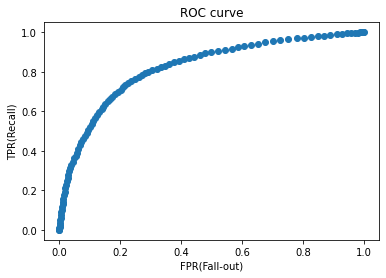

In [25]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [26]:
# 최적의 임계값 찾기 
idx = np.argmax(tpr-fpr)
thred = thresholds[idx]

idx, thred

(55, 0.46)

In [27]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.8233378411736243